# Initial results DAS protocol vs scenario with attackers

## DAS protocol

* The network is formed of a single builder that is generating the block with all samples and `N` nodes distributed between validators and regular nodes.
* Builder knows all the validators
* All nodes have a unique indentifier 256 bits, following the Kademlia procotol and used in DEVP2P.
* We assume DAS protocol Kademlia DHT or DEVp2p. We reuse identifiers and we can use DEVP2P to discover peers. However it is not necessary to use DEVP2P or Kademlia as long as we have nodes with random uniformly distributed identifiers and a way to discover nodes and resolve nodes identifiers to connection parameters.
* Builder divides the hash space into 512*512 cell-specific regions
* Builder transforms the 2D block matrix into a two 1D line of cells (1 line row-wise, and 1 line column-wise, i.e, 1 line row-wise means that after all samples in the first row we continue by the first sample of the second row. 1 line column-wise we mean we first start with all the samples of the first column and then we continue with the samples of the second column)
* We assign samples in the hash space with the double 1D aligment. Every sample is defined by a double id in the hash space, one following row-wise and another column-wise order. This way when fetching rows we can find colocated samples, but also when fetching columns.
* Builder chooses the redundancy factor `redundancy` - the higher `redundancy` the higher overhead but the more resistant the scheme becomes to malicious validators
* The region of cell `c` is defined as all the validators such that `dict(c, v) <= ((2^256 -1) * redundancy) / N_validators * 2`
* The validator pushes each cell to all the validators within the cell's region (Note that it's done in batches - i.e., the builder connects to each validator and gives them all the cells they should hold)

* When a new block is released, nodes got the samples from builder, according to the redundancy parameter and their id. After getting the assigned samples, they start the sampling process.
* Validators sampling consists in getting 2 rows 2 columns of the samples cell.
* Random sampling consists in gettting 75 random samples.
* One of the rows and one of the columns to download is choosen by selecting the row or column that already downloaded the highest number of cells from the builder.
* The second row and column to download is selected randomly.
* Validators perform validator sampling and random sampling. Non-validator nodes they just perform random sampling.
* The validator sampling and random sampling follows the same process with the only difference of selecting the samples to obtain. We call sampling nodes, the nodes requesting samples, and serving nodes the nodes replying with samples:
    - Sampling nodes select a set of replying nodes from a list of known nodes that are within the redundancy range following the id space for the samples requesting (how all nodes of the network are discovered is not included in this initial report, but will be in the following reports. Validators are supposed to know all other validators by default).
    - Sampling nodes send samples requests to the replying nodes selected. Samples requests include the wanted samples (all samples pending to be received are included in the requests).
    - Replying nodes reply with the samples requested they have, and also with known nodes to the same distance, from their Kademlia routing table. This way nodes can easily discover kew nodes in the network.
    - Only Alpha requests can be sent at the same time. After sending initially Alpha requests, a response must be received after sending the next request. Alpha is a configurable parameter.
    - For validator sampling the process is stopped after getting half of the row or column. We consider is not necessary to obtain the rest of the samples, since can be obtained reconstructing.
    - Random sampling process stops when all samples are obtained.

## Malicious protocol

* Some of both validator and regular nodes might be malicious. 
* Malicious behaviour is just ignoring samples requests.



## Simulation parameters

* Number of nodes: 5000
* Number of attackers: Range from 0% to 50%
* Number of validators: All nodes are validators
* Overhead parameter: 2
* Latency between nodes: 100ms
* Number of samples per block : 512x512
* Sample size: 512 bytes
* Blocks: Single block simulation.
* Number of random samples fetch: 75. 
* Alpha: 3

The following cell is just loading traces files into a dataframe

In [6]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

ops_path = {'DAS': '../logsTest/operation.csv', 
            'Evil-0.1': '../logsEvil0.1/operation.csv',
            'Evil-0.2': '../logsEvil0.2/operation.csv',
            'Evil-0.3': '../logsEvil0.3/operation.csv',
            'Evil-0.4': '../logsEvil0.4/operation.csv',
            'Evil-0.5': '../logsEvil0.5/operation.csv'
           }
msgs_path = {'DAS': '../logsTest/messages.csv', 
            'Evil-0.1': '../logsEvil0.1/messages.csv',
            'Evil-0.2': '../logsEvil0.2/messages.csv',
            'Evil-0.3': '../logsEvil0.3/messages.csv',
            'Evil-0.4': '../logsEvil0.4/messages.csv',
            'Evil-0.5': '../logsEvil0.5/messages.csv'
           }


builder_address = '83814183170291850251680823880522715558189094423550585243365458794131648333116'

op_df={}
msg_df={}
for key in ops_path:
    op_df[key] = pd.read_csv(ops_path[key],index_col=False,low_memory=False)
for key in msgs_path:
    msg_df[key] = pd.read_csv(msgs_path[key],index_col=False,low_memory=False)


In this graph we observe the CDF of the time required to complete the validator sampling of the DAS protocol, with and without attackers in the simulation, from 0\% to 50\% of attackers in the simulation.
We observe in all cases the validator sampling is completed on time, with small differences on the time required.

Text(0.5, 0, 'Operation complete time (ms)')

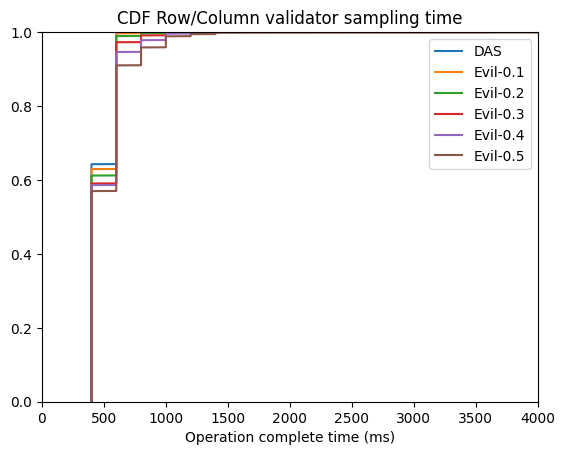

In [8]:
fig3, ax3 = plt.subplots()


for key in op_df:

    vsdf = op_df[key].loc[(op_df[key]['type'] == 'ValidatorSamplingOperation')]

    x = np.sort(vsdf['completion_time'])
    N = vsdf['completion_time'].count()
    # get the cdf values of y
    y = np.arange(N) / float(N)

    ax3.plot(x, y,label=key)

ax3.set_xlim([0,4000])
ax3.legend()
ax3.set_ylim([0,1])

ax3.set_title("CDF Row/Column validator sampling time")
ax3.set_xlabel("Operation complete time (ms)")

In this graph we observe the CDF of the hops (nodes contacted) required to complete the validator sampling of the DAS protocol, with and without attackers in the simulation, from 0\% to 50\% of attackers in the simulation.
We observe in all cases the validator sampling is completed on time, with small differences on the nodes contacted.
We cans ee the maximum  number of hops required is 5, even with 50% malicious nodes.

Text(0.5, 0, '# hops')

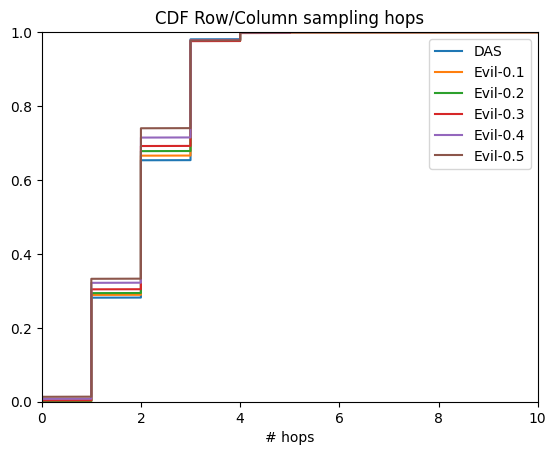

In [10]:
fig8, ax8 = plt.subplots()

for key in op_df:

    vsdf = op_df[key].loc[(op_df[key]['type'] == 'ValidatorSamplingOperation')]

    x = np.sort(vsdf['hops'])
    N = vsdf['hops'].count()
    # get the cdf values of y
    y = np.arange(N) / float(N)

    ax8.plot(x, y,label=key)

ax8.legend()
ax8.set_xlim([0,10])
ax8.set_ylim([0,1])

ax8.set_title("CDF Row/Column sampling hops")
ax8.set_xlabel("# hops")

In this graph we observe the CDF of the time required to complete the random sampling of the DAS protocol, with and without attackers in the simulation, from 0\% to 50\% of attackers in the simulation.
In this case we do observe some performance degradation with scenarios with more than 30\% of malicious nodes.
When 40\% of nodes are attackers, the samples obtained is close to 95\%, and with 50\% is below 70\%.
Note that we have not evaluated DAS protocol with any complementary method to get samples when sampling fails. These methods could be:
 - Getting missing samples directly from the builder.
 - Getting missing samples from validators they downloaded the row or column for that sample.
 - Trying to obtain 10 additional samples for each missing sample.

In next reports we will include an evaluation of different methods could be applied to improve random sampling in the presence of attackers.

Text(0.5, 0, 'Operation complete time (ms)')

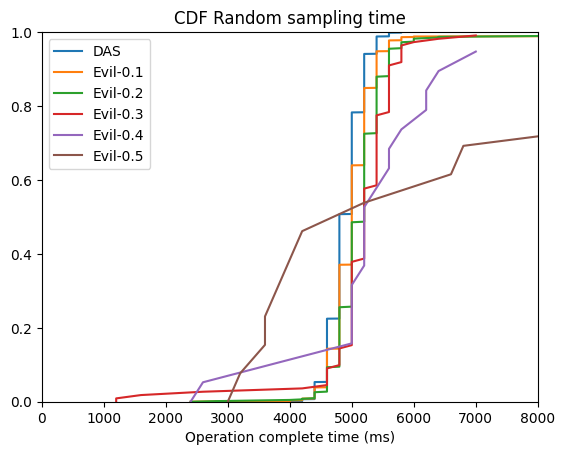

In [11]:
fig4, ax4 = plt.subplots()

for key in op_df:

    rsdf = op_df[key].loc[(op_df[key]['type'] == 'RandomSamplingOperation')]

    x = np.sort(rsdf['completion_time'])
    N = rsdf['completion_time'].count()
    # get the cdf values of y
    y = np.arange(N) / float(N)

    ax4.plot(x, y,label=key)

ax4.legend()
ax4.set_xlim([0,8000])
ax4.set_ylim([0,1])

ax4.set_title("CDF Random sampling time")
ax4.set_xlabel("Operation complete time (ms)")

In this graph we observe the CDF of the nodes contacted required to complete the random sampling of the DAS protocol, with and without attackers in the simulation, from 0\% to 50\% of attackers in the simulation.
The hops required are between 50 and 75 for most of the cases , except for scenarios with 50\%, that the nodes contacted can reach higher than 100, and without completing the sampling in some cases.

Text(0.5, 0, '# hops')

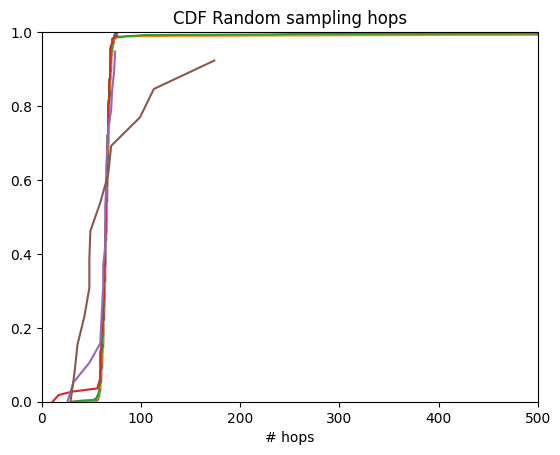

In [14]:
fig9, ax9 = plt.subplots()

for key in op_df:

    rsdf = op_df[key].loc[(op_df[key]['type'] == 'RandomSamplingOperation')]

    x = np.sort(rsdf['hops'])
    N = rsdf['hops'].count()
    # get the cdf values of y
    y = np.arange(N) / float(N)

    ax9.plot(x, y,label=key)

ax9.legend
ax9.set_xlim([0,500])
ax9.set_ylim([0,1])

ax9.set_title("CDF Random sampling hops")
ax9.set_xlabel("# hops")